## Perform survival analysis using HRV metrics to predict mortality.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter


# 1. Load and Preprocess the Data

## Handle type and missing data

In [2]:
df = pd.read_csv('hrv_covariates_outcomes.csv')

# Categorical features
df['EVENT'] = df['EVENT'].apply(lambda x: 1 if x == 0 else 0) # Correct to match lifelines survival analysis library
df['GENDER'] = df['GENDER'].apply(lambda x: 1 if x == 2 else 0) # Make it binary


# We can also remove the ID column we won't need it now
df = df.drop(columns=['NSRRID'])

# Define subsets of columns to make the analysis easier
survival_analysis_columns = ['EVENT', 'DURATION'] # related to survival analysis
all_features_columns = [col for col in df.columns if col not in survival_analysis_columns] # all feature columns 
binary_features_columns = ['GENDER', 'HYPERTENSION']
continuous_features_columns = [col for col in all_features_columns if col not in binary_features_columns] 


In [3]:
# Identify missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0] 

# Print missing values (if any)
if not missing_values.empty:
    print("Missing Values:")
    print(missing_values.to_frame(name="Count"))
    
    # Fill missing values in CHOLESTEROL with the median
    print("\n Replacing missing values with median (better than mean for skewed distributions)")
    df['CHOLESTEROL'] = df['CHOLESTEROL'].fillna(df['CHOLESTEROL'].median())

    # Check for remaining missing values
    missing_values_after = df.isnull().sum()
    missing_values_after = missing_values_after[missing_values_after > 0]

    if missing_values_after.empty:
        print("\n No more missing values!")
    else:
        print("\nRemaining Missing Values :")
        print(missing_values_after.to_frame(name="Count"))
else:
    print("No missing values detected.")

Missing Values:
             Count
CHOLESTEROL      4

 Replacing missing values with median (better than mean for skewed distributions)

 No more missing values!


## Describe the dataframe before applying any modifications to it

In [4]:
df_description = df.describe().round(2)
df_description

,AGE,GENDER,BMI,CHOLESTEROL,HYPERTENSION,AVNN,SDNN,RMSSD,pNN50,ULF_norm,VLF_norm,LF_norm,HF_norm,VHF_norm,LF_HF_ratio,SD1,SD2,EVENT,DURATION
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,61.26,0.50,28.01,204.32,0.42,936.52,140.79,114.99,16.81,12.64,22.33,21.88,28.55,11.93,1.16,81.31,177.19,0.26,4116.24
std,10.27,0.51,4.54,28.97,0.50,145.62,73.56,109.78,18.05,8.38,11.71,7.09,13.37,9.50,1.15,77.63,80.37,0.44,1037.68
min,43.00,0.00,18.00,146.00,0.00,611.60,55.47,14.19,0.29,1.90,3.40,6.12,3.52,0.30,0.12,10.03,77.81,0.00,807.00
25%,54.50,0.00,25.73,180.50,0.00,838.26,95.48,54.38,4.89,6.00,12.93,18.72,16.80,4.96,0.56,38.46,128.43,0.00,3809.50
50%,59.00,0.50,27.21,206.50,0.00,925.99,131.17,78.60,12.10,10.92,21.33,21.77,29.64,10.60,0.71,55.58,168.22,0.00,4371.50
75%,70.50,1.00,30.19,223.50,1.00,1044.10,161.49,128.01,19.24,18.05,31.51,25.16,41.01,14.81,1.44,90.52,211.67,0.75,4854.25
max,81.00,1.00,40.45,267.00,1.00,1288.64,509.12,680.19,88.53,36.22,46.11,51.45,49.42,41.56,6.30,480.97,535.72,1.00,5593.00


## Variance and Balance


In [5]:
# Proportion of 1s in each binary feature
binary_proportion = df[binary_features_columns].mean()  
print("Binary proportion:")
print(binary_proportion, '\n')

# Variance of each continuous feature
variance = df[continuous_features_columns].var()
print("Variance of each column:")
print(variance)

Binary proportion:
GENDER          0.50
HYPERTENSION    0.42
dtype: float64 

Variance of each column:
AGE              105.543265
BMI               20.655607
CHOLESTEROL      839.507755
AVNN           21204.263448
SDNN            5411.040441
RMSSD          12052.341209
pNN50            325.942737
ULF_norm          70.224755
VLF_norm         137.075353
LF_norm           50.208122
HF_norm          178.832463
VHF_norm          90.332562
LF_HF_ratio        1.321254
SD1             6026.166883
SD2             6459.400047
dtype: float64


/var/folders/nk/ctx5v5kd62l2xk1gz7kgm5vr0000gn/T/ipykernel_1951/1179108057.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variance.index, y=variance.values, palette='viridis')


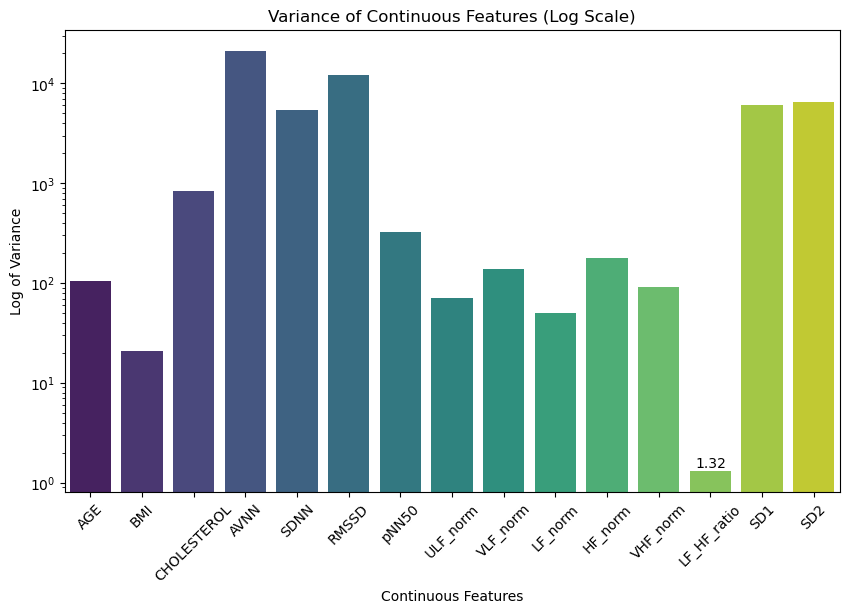

In [6]:
# Plot 2: Variance of Continuous Features (Logarithmic Scale)
plt.figure(figsize=(10, 6))
sns.barplot(x=variance.index, y=variance.values, palette='viridis')

# Apply log scale to y-axis for better visibility of smaller values
plt.yscale('log')

# Title and labels
plt.title('Variance of Continuous Features (Log Scale)')
plt.xlabel('Continuous Features')
plt.ylabel('Log of Variance')

# Rotate the x-ticks for better readability
plt.xticks(rotation=45)

# Annotate the bars with variance values greater than 10
for i, v in enumerate(variance.values):
    if v < 10:  # Only annotate values greater than 10
        plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)  # Display number without scientific notation

plt.show()

/var/folders/nk/ctx5v5kd62l2xk1gz7kgm5vr0000gn/T/ipykernel_1951/2100300649.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=binary_proportion.index, y=binary_proportion.values, palette='viridis')


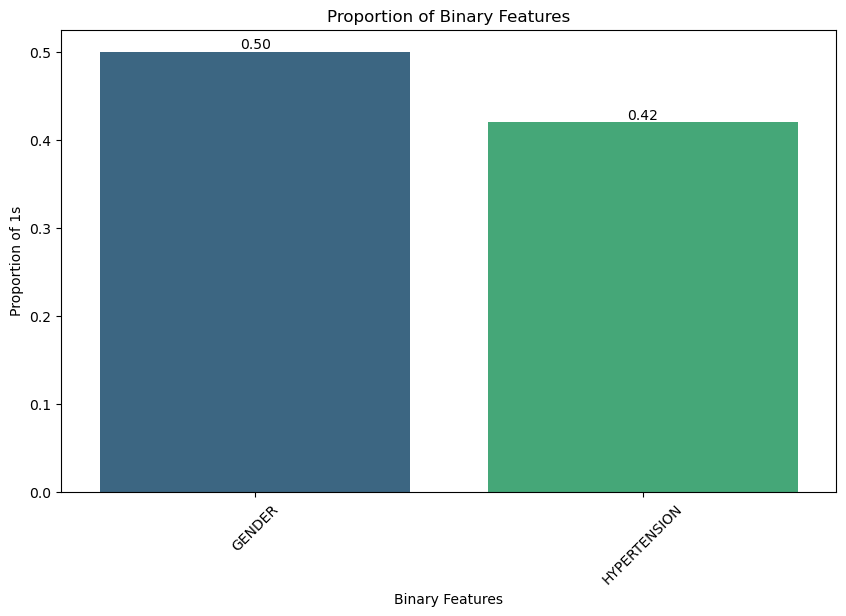

In [7]:
# Plot: Proportion of Binary Features
plt.figure(figsize=(10, 6))
sns.barplot(x=binary_proportion.index, y=binary_proportion.values, palette='viridis')

# Title and labels
plt.title('Proportion of Binary Features')
plt.xlabel('Binary Features')
plt.ylabel('Proportion of 1s')

# Rotate the x-ticks for better readability
plt.xticks(rotation=45)

# Annotate the bars with proportions
for i, v in enumerate(binary_proportion.values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)  # Display number without scientific notation

plt.show()

We have a good balance for binary features and quite high variance for the continuous variable, thus we don't dorp any of them.

## Correlation


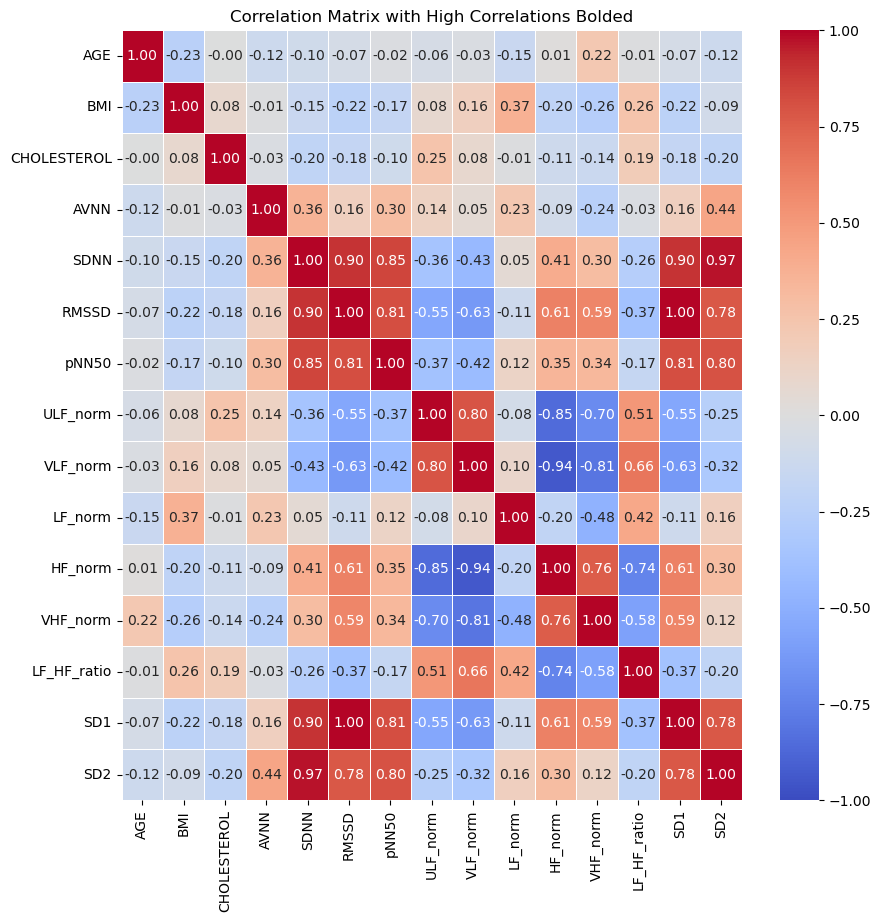

In [8]:
# Calcul de la matrice de corrélation pour les features continues
correlation_matrix = df[continuous_features_columns].corr()

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix with High Correlations Bolded')
plt.show()

Features to drop (correlated above threshold):
{'SD1', 'SD2', 'HF_norm', 'RMSSD'}


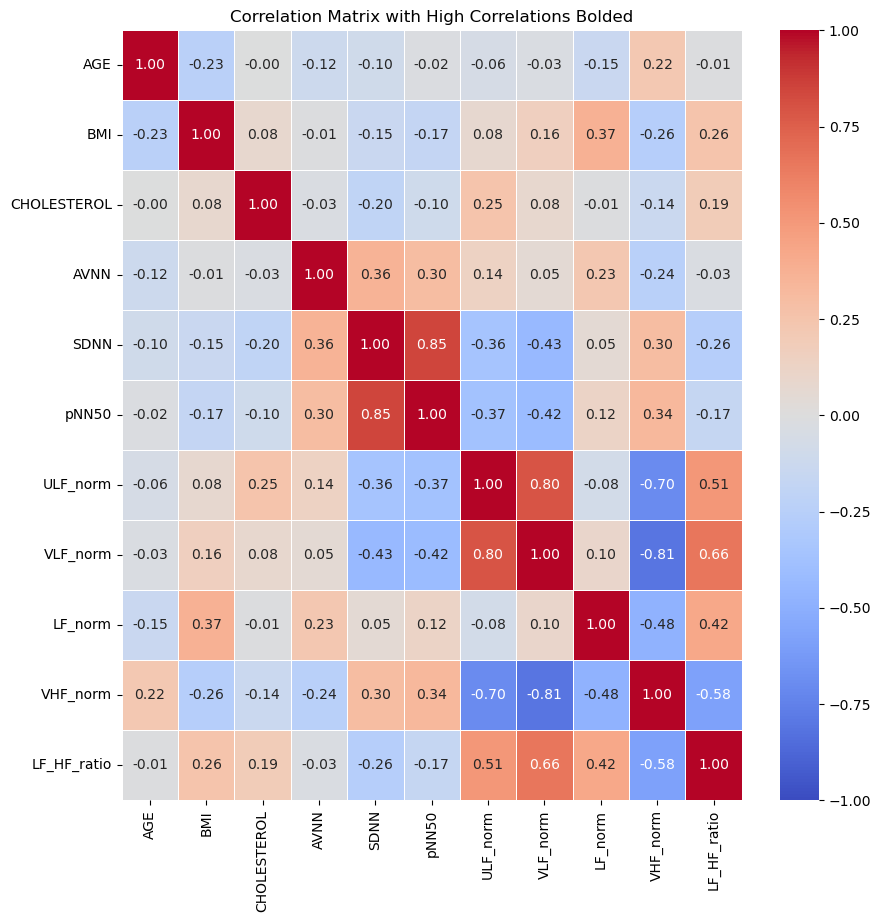

In [9]:
# Example: Set the threshold for correlation
threshold = 0.9

# Calculate the correlation matrix for continuous features
corr_matrix = df[continuous_features_columns].corr()

# Identify features to drop (those with correlation above the threshold)
to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

# Print the features to drop
print("Features to drop (correlated above threshold):")
print(to_drop)

# Remove the highly correlated features from the DataFrame
df = df.drop(columns=to_drop)

# Remove the features from the continuous features list
continuous_features_columns = [col for col in continuous_features_columns if col not in to_drop]
all_features_columns = [col for col in all_features_columns if col not in to_drop]

# Calcul de la matrice de corrélation pour les features continues
correlation_matrix = df[continuous_features_columns].corr()

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix with High Correlations Bolded')
plt.show()

Note that data really need to be uncorrelated for Cox Regression.

## Standardize the continous features

In [10]:
scaler = StandardScaler()
df[continuous_features_columns] = scaler.fit_transform(df[continuous_features_columns])

# 2. Look the surival curves for our subset 

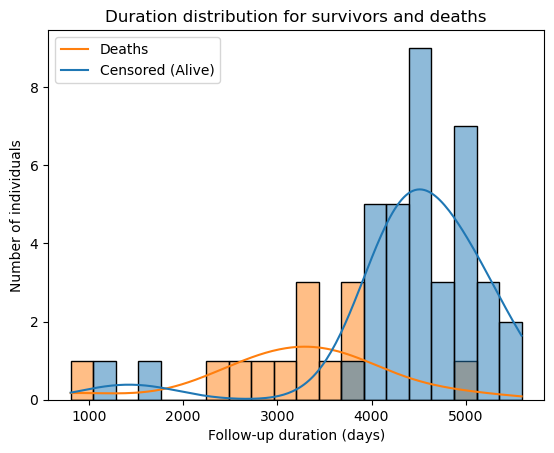

In [11]:
# Create the histogram 
sns.histplot(data=df, x="DURATION", hue="EVENT", kde=True, bins=20)
plt.xlabel("Follow-up duration (days)")
plt.ylabel("Number of individuals")
plt.title("Duration distribution for survivors and deaths")
plt.legend(labels=["Deaths","Censored (Alive)"])
plt.show()

<Axes: xlabel='timeline'>

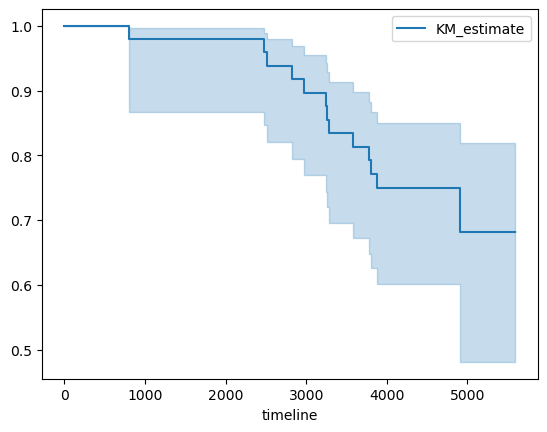

In [12]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df["DURATION"], event_observed=df["EVENT"])
kmf.plot()

# 3. Multivariate Analysis

## Multivariate survival analysis with the HRV metrics

In [13]:
def multivariate_cox_analysis(df, features_columns):
    # Prepare the data for Cox model
    df_cox = df.loc[:, ["DURATION", "EVENT"] + features_columns].copy()

    # Initialize Cox Proportional Hazards model
    cph = CoxPHFitter()       
    cph.fit(df_cox, duration_col="DURATION", event_col="EVENT")

    # Extract the summary table for the coefficients and include additional metrics
    cph_summary = cph.summary[['coef', 'exp(coef)', 'se(coef)', 'z', 'p']].copy()
    cph.plot()

    # Test the proportional hazards assumption using Schoenfeld residuals for continuous features
    results = proportional_hazard_test(cph, df_cox)
    for feature, p_value in results.test_statistic.items():  # Access p-values correctly
        if p_value>0.05:
            print(f"Schoenfeld Residuals test p-value for {feature}: {p_value:.4f} ✅ ")
        else:
            print(f"Schoenfeld Residuals test p-value for {feature}: {p_value:.4f} ❌ ")
    print('-'*70)
    print('AIC:', cph.AIC_partial_)
    print('C-index:', cph.concordance_index_)
    
    return cph_summary

Schoenfeld Residuals test p-value for AVNN: 0.1532 ✅ 
Schoenfeld Residuals test p-value for LF_HF_ratio: 0.5807 ✅ 
Schoenfeld Residuals test p-value for LF_norm: 0.0316 ❌ 
Schoenfeld Residuals test p-value for SDNN: 2.1865 ✅ 
Schoenfeld Residuals test p-value for ULF_norm: 0.5379 ✅ 
Schoenfeld Residuals test p-value for VHF_norm: 0.0233 ❌ 
Schoenfeld Residuals test p-value for VLF_norm: 0.0000 ❌ 
Schoenfeld Residuals test p-value for pNN50: 0.4281 ✅ 
----------------------------------------------------------------------
AIC: 92.16525757202503
C-index: 0.7701375245579568


,coef,exp(coef),se(coef),z,p
covariate,,,,,
AVNN,0.561760,1.753756,0.358768,1.565801,0.117395
LF_HF_ratio,-0.449221,0.638125,0.885162,-0.507501,0.611803
LF_norm,1.668483,5.304114,0.874243,1.908489,0.056328
SDNN,-0.629686,0.532759,0.842380,-0.747508,0.454757
ULF_norm,1.882383,6.569141,0.875398,2.150318,0.031530
VHF_norm,3.285799,26.730328,1.316597,2.495675,0.012572
VLF_norm,-0.099623,0.905178,1.073153,-0.092832,0.926037
pNN50,-1.295741,0.273695,0.911690,-1.421252,0.155244


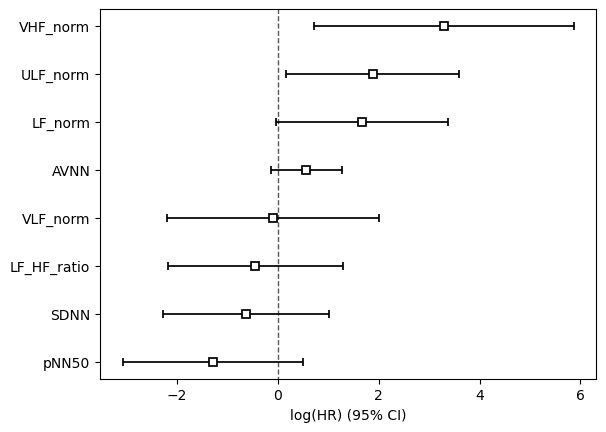

In [14]:
hrv_columns = ['AVNN', 'SDNN', 'pNN50', 'ULF_norm', 'VLF_norm', 'LF_norm', 'VHF_norm', 'LF_HF_ratio']
multivariate_cox_results_without_covariates = multivariate_cox_analysis(df, sorted(hrv_columns))
multivariate_cox_results_without_covariates

If we examine the Cox Proportional Hazards model, we notice 3 interesting p-values: `ULF` and `VHF` are significant, while `LF` is very close to the significance threshold.  

However, when checking the Schoenfeld Residuals test, both `LF` and `VHF` potentially violate the proportional hazards assumption, meaning their effects on survival are not constant over time.

	This suggests that `ULF` is the only HRV metric that remains valid under this assumption.  

Yet, when looking at the hazard ratio plot, `ULF` has a positive coefficient (1.88), implying that a higher ULF percentage is associated with an increased risk of death. This contradicts physiological expectations, as higher ULF is typically linked to better autonomic balance and lower mortality risk.  

Thus, this model does not seem reliable. The `AIC` (92) is high, indicating a less optimal fit, while the `C-index` (0.77) is decent but could be improved.


## Multivariate survival analysis with the HRV metrics + AGE

Schoenfeld Residuals test p-value for AGE: 0.5151 ✅ 
Schoenfeld Residuals test p-value for AVNN: 0.0039 ❌ 
Schoenfeld Residuals test p-value for LF_HF_ratio: 0.0421 ❌ 
Schoenfeld Residuals test p-value for LF_norm: 0.1527 ✅ 
Schoenfeld Residuals test p-value for SDNN: 0.7497 ✅ 
Schoenfeld Residuals test p-value for ULF_norm: 0.0017 ❌ 
Schoenfeld Residuals test p-value for VHF_norm: 0.3305 ✅ 
Schoenfeld Residuals test p-value for VLF_norm: 0.1280 ✅ 
Schoenfeld Residuals test p-value for pNN50: 0.0105 ❌ 
----------------------------------------------------------------------
AIC: 72.60230751205185
C-index: 0.9174852652259332


,coef,exp(coef),se(coef),z,p
covariate,,,,,
AGE,3.279559,26.564061,1.122248,2.922314,0.003474
AVNN,0.254714,1.290092,0.306350,0.831446,0.405722
LF_HF_ratio,-3.289431,0.037275,1.839042,-1.788666,0.073669
LF_norm,4.779355,119.027514,2.023292,2.362167,0.018168
SDNN,-2.543565,0.078586,1.294705,-1.964591,0.049462
ULF_norm,5.521513,250.012910,2.116272,2.609076,0.009079
VHF_norm,5.752721,315.046864,2.570276,2.238173,0.025210
VLF_norm,-0.263396,0.768437,1.176052,-0.223966,0.822783
pNN50,-1.228083,0.292853,1.073308,-1.144203,0.252539


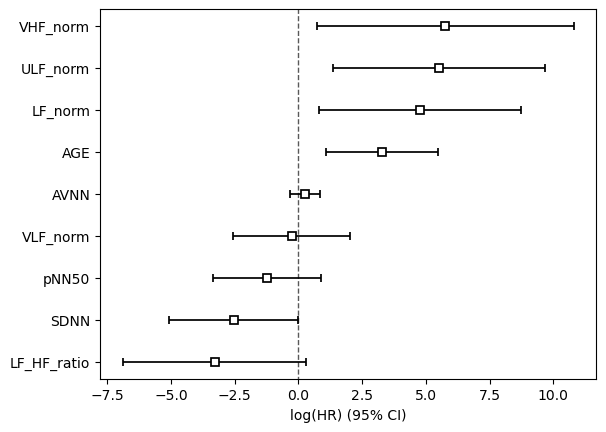

In [15]:
# features_without_age = [feature for feature in all_features_columns if feature != 'AGE']
hrv_columns_age = hrv_columns
hrv_columns_age.append('AGE')
multivariate_cox_results_with_age = multivariate_cox_analysis(df, sorted(hrv_columns_age))
multivariate_cox_results_with_age

One key covariate that must be included in our model is Age. It is an obvious and well-established factor influencing mortality, so incorporating it into our model is essential.  


When examining the Cox Proportional Hazards model, we observe five significant p-values:
- `AGE`, confirming that our data and model make sense.
- `LF`, `ULF`, and `VHF`, which were already significant in the previous model.
- `SDNN`, which now appears significant as well.  

However, checking the Schoenfeld Residuals test, we find that `ULF` violates the proportional hazards assumption, meaning its effect on survival is not constant over time. On the other hand, `AGE`, `LF`, `VHF`, and `SDNN` pass the test, making them valid and significant predictors in this updated model.

This indicates a clear improvement over the previous model, as seen in the decrease in `AIC` (from 92 to 72) and increase in `C-index` (from 0.77 to 0.91), both showing a much better fit and predictive performance.

Moreover, these results suggest that `AGE` is a confounder in the relationship between HRV metrics and survival. By including Age, the most important HRV metrics shift—previously, `ULF` was a key predictor, but now `SDNN`, `LF`, and `VHF` take precedence.  

-----

Looking at the hazard ratio plot:
- `AGE` has a positive coefficient, as expected—older individuals have a higher risk of mortality.
- `VHF` also has a positive coefficient, which aligns with literature expectation.
- `SDNN` has a negative coefficient, which is expected—lower SDNN indicates better HRV and autonomic function, which correlates with improved survival and lower mortality risk.
- `LF` has a large positive coefficient, which may depend on the context but can be physiologically plausible (explain why).

-----

By adding Age as a confounding variable, our model has improved significantly. Three HRV metrics (`SDNN`, `LF`, `VHF`) remain significant, and all pass the proportional hazards assumption check.
The `AIC` and `C-index` confirm this is a much stronger and more reliable model, demonstrating the importance of accounting for Age when analyzing HRV and survival.


## Multivariate survival analysis with the HRV metrics + ALL COVARIATES

Schoenfeld Residuals test p-value for AGE: 0.2253 ✅ 
Schoenfeld Residuals test p-value for AVNN: 0.0024 ❌ 
Schoenfeld Residuals test p-value for BMI: 1.2025 ✅ 
Schoenfeld Residuals test p-value for CHOLESTEROL: 0.1240 ✅ 
Schoenfeld Residuals test p-value for GENDER: 1.7738 ✅ 
Schoenfeld Residuals test p-value for HYPERTENSION: 1.4430 ✅ 
Schoenfeld Residuals test p-value for LF_HF_ratio: 0.1456 ✅ 
Schoenfeld Residuals test p-value for LF_norm: 0.4124 ✅ 
Schoenfeld Residuals test p-value for SDNN: 1.7021 ✅ 
Schoenfeld Residuals test p-value for ULF_norm: 0.0657 ✅ 
Schoenfeld Residuals test p-value for VHF_norm: 0.3590 ✅ 
Schoenfeld Residuals test p-value for VLF_norm: 0.2450 ✅ 
Schoenfeld Residuals test p-value for pNN50: 0.5513 ✅ 
----------------------------------------------------------------------
AIC: 74.39856044675523
C-index: 0.93713163064833


,coef,exp(coef),se(coef),z,p
covariate,,,,,
AGE,4.096517,60.130458,1.274115,3.215187,0.001304
AVNN,0.619895,1.858734,0.393634,1.574803,0.115302
BMI,0.335777,1.399028,0.506902,0.662411,0.507708
CHOLESTEROL,-1.067786,0.343769,0.688713,-1.550408,0.121044
GENDER,-2.030873,0.131221,1.385783,-1.465506,0.142783
HYPERTENSION,0.659488,1.933802,1.095147,0.602191,0.547047
LF_HF_ratio,-3.802831,0.022308,2.759654,-1.378010,0.168200
LF_norm,4.758835,116.610030,2.357086,2.018948,0.043493
SDNN,-5.369902,0.004655,2.536946,-2.116680,0.034287


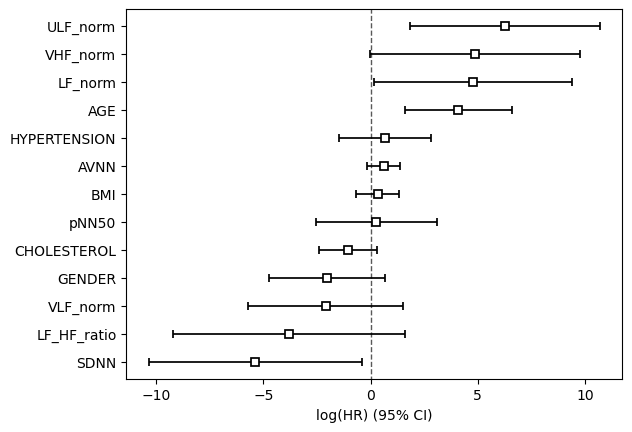

In [16]:
# features_without_age = [feature for feature in all_features_columns if feature != 'AGE']
multivariate_cox_results_with_covariates = multivariate_cox_analysis(df, sorted(all_features_columns))
multivariate_cox_results_with_covariates

Since Age improved our model significantly, let’s now include multiple covariates: Age, Gender, Cholesterol, and Hypertension.  

We observe the same five significant variables as before: `AGE`, `LF`, `ULF`, `SDNN`, and `VHF` (on the threshold). 
Importantly, they all pass the proportional hazards assumption check, meaning their effects on survival remain constant over time—making this model much more reliable and robust.  

Additionally, we see a small improvement in the `C-index`, indicating a slight increase in predictive power. The `AIC` increases slightly, but this trade-off suggests that the model is capturing more meaningful variability.  
 
This is a very promising model, as we now have nearly all covariates meeting the key statistical assumptions.  

-----

Hazard Ratio Plot Interpretation
- `AGE`, `VHF`, and `LF` → Positive coefficients: Higher values are associated with increased mortality risk, which aligns with expectations.
- `SDNN` → Negative coefficient: Higher SDNN reflects better HRV and autonomic function, which correlates with improved survival and lower mortality risk.

----

Adding `AGE`, `GENDER` (male), `CHOLESTEROL`, `HYPERTENSION` further refines the model while keeping LF, SDNN, ULF, and VHF as key HRV metrics for survival.    
The fact that nearly all variables pass the proportional hazards assumption makes this model both statistically strong and highly promising for interpretation. Age is the main confounder improving the model; other variables (Gender, Cholesterol, Hypertension) are potential confounders but have a lesser impact.



# 4. Univariate analysis for obtained significant features

In [17]:
def univariate_cox_analysis(df, features_columns):
    # Create an empty list to store summary results for each feature
    summary_results = []

    # Loop through each feature and perform univariate Cox analysis
    for feature in features_columns:
        # Prepare the data for Cox model
        df_cox = df.loc[:, ["DURATION", "EVENT", feature]].copy()

        # Fit the Cox model
        cph = CoxPHFitter()
        cph.fit(df_cox, duration_col="DURATION", event_col="EVENT")

        # Extract the main summary information
        cph_summary = cph.summary
        main_info = cph_summary[['coef', 'exp(coef)', 'se(coef)', 'z', 'p']].copy()  
        
        # Get the C-index
        main_info.loc[:, 'C-Index'] = cph.concordance_index_

        # Append the result to the summary list
        summary_results.append(main_info)

    # Concatenate all the results and set the feature as the index
    final_summary_table = pd.concat(summary_results)

    return final_summary_table

univariate_cox_results = univariate_cox_analysis(df, all_features_columns)
univariate_cox_results

,coef,exp(coef),se(coef),z,p,C-Index
covariate,,,,,,
AGE,1.301676,3.675453,0.377450,3.448610,0.000563,0.775049
GENDER,0.183802,1.201778,0.556746,0.330136,0.741297,0.512770
BMI,-0.272925,0.761150,0.305709,-0.892762,0.371984,0.565815
CHOLESTEROL,-0.106645,0.898845,0.272519,-0.391330,0.695553,0.540275
HYPERTENSION,1.381546,3.981051,0.603063,2.290881,0.021970,0.661100
AVNN,-0.098753,0.905967,0.297386,-0.332069,0.739837,0.512770
SDNN,-0.270005,0.763376,0.349445,-0.772667,0.439720,0.506876
pNN50,-0.071792,0.930724,0.275582,-0.260511,0.794469,0.467583
ULF_norm,-0.251556,0.777590,0.306655,-0.820323,0.412032,0.546169


In [18]:
def survival_analysis_with_logrank(df, feature_name, avg_info):
    # 1. Create two groups based on the feature (e.g., Above vs. Below Average)
    subgroups = df[feature_name].apply(lambda x: f'Below Average {avg_info}' if x < 0 else f'Above Average {avg_info}')

    # 2. Kaplan-Meier Survival Curves for each group
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))
    
    for group in subgroups.unique():
        mask = subgroups == group
        kmf.fit(df.loc[mask, "DURATION"], event_observed=df.loc[mask, "EVENT"], label=group)
        kmf.plot()

    plt.title(f"Kaplan-Meier Survival Curve by {feature_name} Group")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend(title=f"{feature_name} Groups")
    plt.show()

    # 3. Perform Log-Rank Test to check if survival curves are significantly different
    below_avg = df.loc[subgroups == f'Below Average {avg_info}']
    above_avg = df.loc[subgroups == f'Above Average {avg_info}']

    print(f"Below Avg Group Size: {below_avg.shape[0]}")
    print(f"Above Avg Group Size: {above_avg.shape[0]}")
    
    results = logrank_test(below_avg['DURATION'], above_avg['DURATION'],
                           event_observed_A=below_avg['EVENT'], event_observed_B=above_avg['EVENT'])
    
    # Print the p-value of the log-rank test
    if results.p_value < 0.005:
        print(f"Log-rank test p-value: {results.p_value} ✅")
    else:
        print(f"Log-rank test p-value: {results.p_value} ❌")

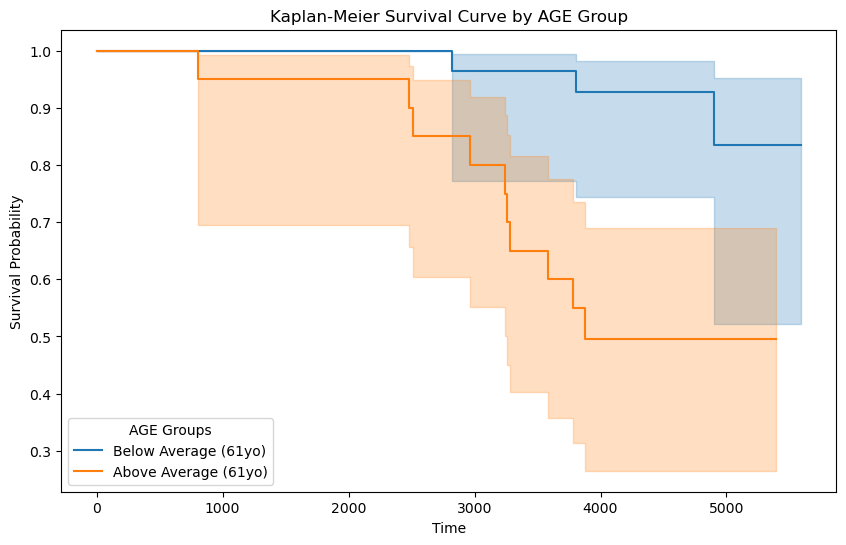

Below Avg Group Size: 30
Above Avg Group Size: 20
Log-rank test p-value: 0.000690463717229574 ✅


In [19]:
mean_age = int(df_description.loc['mean', 'AGE'])
survival_analysis_with_logrank(df, feature_name="AGE", avg_info=f"({mean_age}yo)")

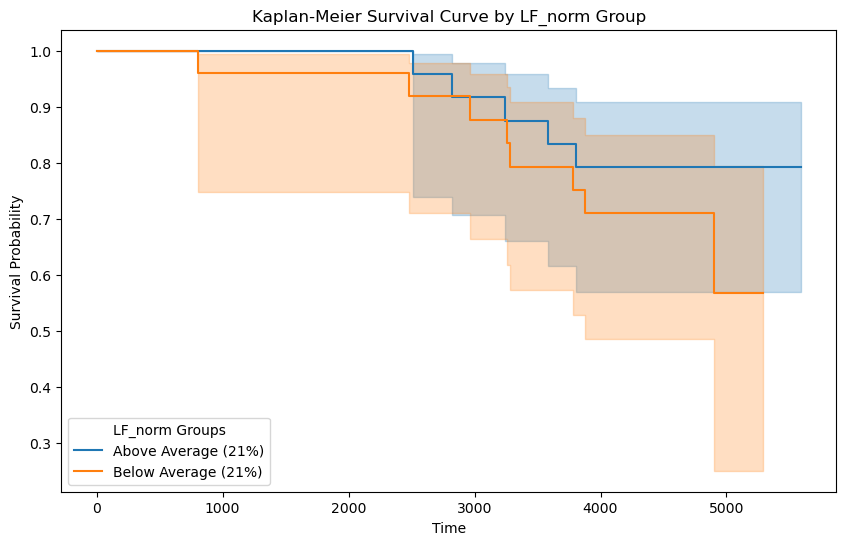

Below Avg Group Size: 25
Above Avg Group Size: 25
Log-rank test p-value: 0.3519422125469026 ❌


In [20]:
mean_LF_norm = int(df_description.loc['mean', 'LF_norm'])
survival_analysis_with_logrank(df, feature_name="LF_norm", avg_info=f"({mean_LF_norm}%)")

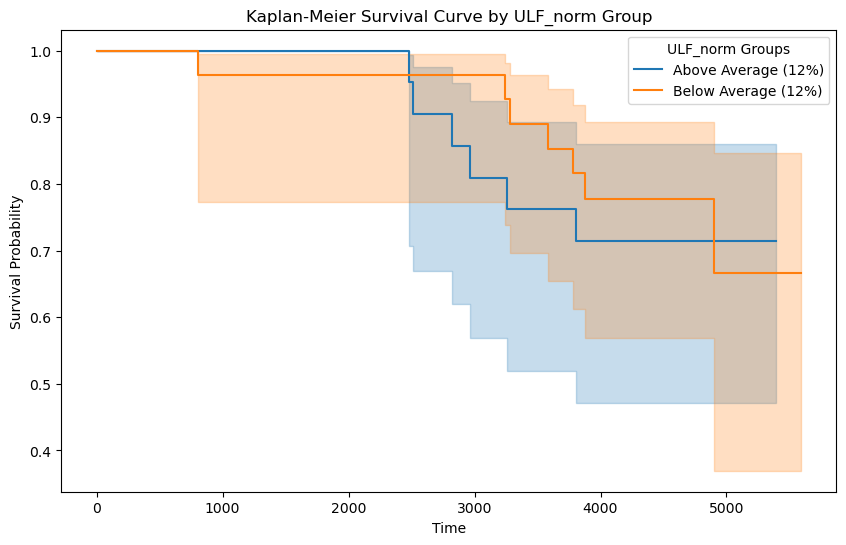

Below Avg Group Size: 28
Above Avg Group Size: 22
Log-rank test p-value: 0.7159421832838341 ❌


In [21]:
mean_ULF_norm = int(df_description.loc['mean', 'ULF_norm'])
survival_analysis_with_logrank(df, feature_name="ULF_norm", avg_info=f"({mean_ULF_norm}%)")

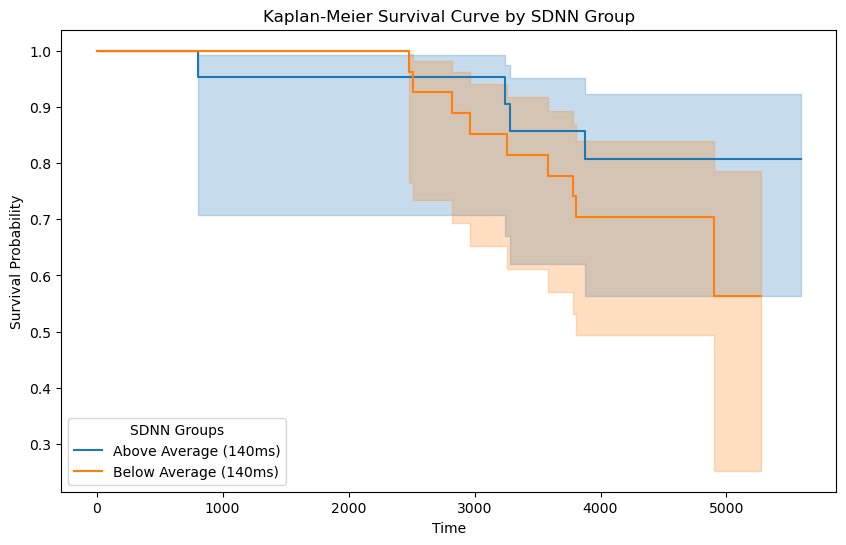

Below Avg Group Size: 29
Above Avg Group Size: 21
Log-rank test p-value: 0.2736796646248941 ❌


In [22]:
mean_SDNN= int(df_description.loc['mean', 'SDNN'])
survival_analysis_with_logrank(df, feature_name="SDNN", avg_info=f"({mean_SDNN}ms)")

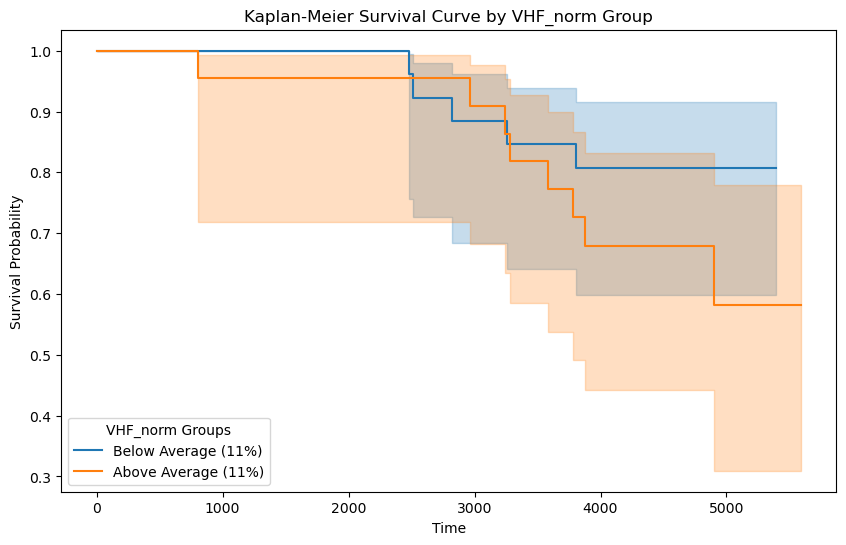

Below Avg Group Size: 28
Above Avg Group Size: 22
Log-rank test p-value: 0.2700991614983203 ❌


In [23]:
mean_VHF_norm = int(df_description.loc['mean', 'VHF_norm'])
survival_analysis_with_logrank(df, feature_name="VHF_norm", avg_info=f"({mean_VHF_norm}%)")

Interpretation of Results
- `AGE` remains significant in both univariate and multivariate models, highlighting its strong impact on mortality.
- HRV metrics (`LF`, `ULF`, `SDNN`, `VHF`) are not significant univariately but become significant in the multivariate model, suggesting their combined effect with age improves survival prediction.